<meta name="twitter:image" content="https://avatars0.githubusercontent.com/u/21003710?s=200&v=4" />

# PyTorch Classification Example

In this notebook, we're going to use ResNet-18 implemented in pyTorch to classify the 5-particle example training data.

This tutorial is meant to walk through some of the necessary steps to load images stored in LArCV files and train a network.  For more details on how to use pytorch, refer to the official pytorch tutorials.

This notebook will try to be self-contained in terms of code. 
However, you can find the code separated into different files in the following repositories

* [LArCVDataset](https://github.com/DeepLearnPhysics/larcvdataset): concrete instance of pytorch Dataset class written for LArCV2 IO
* [pytorch-classification-example](https://github.com/DeepLearnPhysics/pytorch-resnet-example): many of the files and scripts found in this tutorial
* [pytorch resnet implementation](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py): is where we get our implementation with some slight modifications
* [pytorch ImageNet training example](https://github.com/pytorch/examples/blob/master/imagenet/main.py): is where we get the methods for training, again, with some slight modifications

You will also need the training data. Go to the [open data page](http://deeplearnphysics.org/DataChallenge/) and download the either the 5k or 50k training/validation samples.


In [1]:
# Import our modules

# python
import os,sys
import shutil
import time
import traceback

# numpy
import numpy as np

# torch
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

# ROOT/LArCV
import ROOT
from larcv import larcv

%matplotlib notebook
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.12/04


## Set the GPU to use

In [2]:
torch.cuda.device( 1 )

# Setup Data IO

## Location of data on your local machine

Set the path to the data files in this block.

In [3]:
path_to_train_data="/home/taritree/working/dlphysics/testset/train_50k.root"
path_to_test_data="/home/taritree/working/dlphysics/testset/test_40k.root"
if not os.path.exists(path_to_train_data):
    print "Could not find the training data file."
if not os.path.exists(path_to_test_data):
    print "Could not find the validation data file."

## Define LArCVDataset

First, we define a class that will load our data. There are many ways to do this. We create a concrete instance of pytorch's `Dataset` class, which can be used in the `DataLoader` class (which we do not use).

In [4]:
# from: https://github.com/deeplearnphysics/larcvdataset

larcv.PSet # touch this to force libBase to load, which has CreatePSetFromFile
from larcv.dataloader2 import larcv_threadio
from torch.utils.data import Dataset

class LArCVDataset(Dataset):
    """ LArCV data set interface for PyTorch"""

    def __init__( self, cfg, fillername, verbosity=0, loadallinmem=False, randomize_inmem_data=True, max_inmem_events=-1 ):
        self.verbosity = verbosity
        self.batchsize = None
        self.randomize_inmem_data = randomize_inmem_data
        self.max_inmem_events = max_inmem_events
        self.loadallinmem = loadallinmem
        self.cfg = cfg  

        # we setup the larcv threadfiller class, which handles io from larcv files
        # this follows steps from larcv tutorials
        
        # setup cfg dictionary needed for larcv_threadio      
        self.filler_cfg = {}
        self.filler_cfg["filler_name"] = fillername
        self.filler_cfg["verbosity"]   = self.verbosity
        self.filler_cfg["filler_cfg"]  = self.cfg
        if not os.path.exists(self.cfg):
            raise ValueError("Could not find filler configuration file: %s"%(self.cfg))

        # we read the first line of the config file, which should have name of config parameter set
        linepset = open(self.cfg,'r').readlines()
        self.cfgname = linepset[0].split(":")[0].strip()
        
        # we load the pset ourselves, as we want access to values in 'ProcessName' list
        # will use these as the names of the data products loaded. store in self.datalist
        self.pset = larcv.CreatePSetFromFile(self.cfg,self.cfgname).get("larcv::PSet")(self.cfgname)
        datastr_v = self.pset.get("std::vector<std::string>")("ProcessName")
        self.datalist = []
        for i in range(0,datastr_v.size()):
            self.datalist.append(datastr_v[i])
        
        # finally, configure io
        self.io = larcv_threadio()        
        self.io.configure(self.filler_cfg)
        
        if self.loadallinmem:
            self._loadinmem()

    def __len__(self):
        if not self.loadallinmem:
            return int(self.io.fetch_n_entries())
        else:
            return int(self.alldata[self.datalist[0]].shape[0])

    def __getitem__(self, idx):
        if not self.loadallinmem:
            self.io.next()
            out = {}
            for name in self.datalist:
                out[name] = self.io.fetch_data(name).data()
        else:
            indices = np.random.randint(len(self),size=self.batchsize)
            out = {}
            for name in self.datalist:
                out[name] = np.zeros( (self.batchsize,self.alldata[name].shape[1]), self.alldata[name].dtype )
                for n,idx in enumerate(indices):
                    out[name][n,:] = self.alldata[name][idx,:]
        return out
        
    def __str__(self):
        return dumpcfg()
    
    def _loadinmem(self):
        """load data into memory"""
        nevents = int(self.io.fetch_n_entries())
        if self.max_inmem_events>0 and nevents>self.max_inmem_events:
            nevents = self.max_inmem_events

        print "Attempting to load all ",nevents," into memory. good luck"
        start = time.time()

        # start threadio
        self.start(1)

        # get one data element to get shape
        self.io.next()
        firstout = {}
        for name in self.datalist:
            firstout[name] = self.io.fetch_data(name).data()
            self.alldata = {}
        for name in self.datalist:
            self.alldata[name] = np.zeros( (nevents,firstout[name].shape[1]), firstout[name].dtype )
            self.alldata[name][0] = firstout[name][0,:]
        for i in range(1,nevents):
            self.io.next()
            if i%1000==0:
                print "loading event %d of %d"%(i,nevents)
            for name in self.datalist:
                out = self.io.fetch_data(name).data()
                self.alldata[name][i,:] = out[0,:]

        print "elapsed time to bring data into memory: ",time.time()-start,"sec"
        self.stop()

    def start(self,batchsize):
        """exposes larcv_threadio::start which is used to start the thread managers"""
        self.batchsize = batchsize
        self.io.start_manager(self.batchsize)

    def stop(self):
        """ stops the thread managers"""
        self.io.stop_manager()

    def dumpcfg(self):
        """dump the configuration file to a string"""
        print open(self.cfg).read()
        


## Write configuration files for the LArCV ThreadFiller class

We define the configurations in this block, then write to file. We will load the files later when we create LArCVDataset instances for both the training and test data.

A note: the configurations need to have a separate name. Also, the `ProcessNames` have to be different. This is because of the way the threads are managed.

In [5]:
train_cfg="""ThreadProcessor: {
  Verbosity:3
  NumThreads: 3
  NumBatchStorage: 3
  RandomAccess: true
  InputFiles: ["%s"]  
  ProcessName: ["image","label"]
  ProcessType: ["BatchFillerImage2D","BatchFillerPIDLabel"]
  ProcessList: {
    image: {
      Verbosity:3
      ImageProducer: "data"
      Channels: [2]
      EnableMirror: true
    }
    label: {
      Verbosity:3
      ParticleProducer: "mctruth"
      PdgClassList: [2212,11,211,13,22]
    }
  }
}
"""%(path_to_train_data)

test_cfg="""ThreadProcessorTest: {
  Verbosity:3
  NumThreads: 2
  NumBatchStorage: 2
  RandomAccess: true
  InputFiles: ["%s"]
  ProcessName: ["imagetest","labeltest"]
  ProcessType: ["BatchFillerImage2D","BatchFillerPIDLabel"]
  ProcessList: {
    imagetest: {
      Verbosity:3
      ImageProducer: "data"
      Channels: [2]
      EnableMirror: false
    }
    labeltest: {
      Verbosity:3
      ParticleProducer: "mctruth"
      PdgClassList: [2212,11,211,13,22]
    }
  }
}
"""%(path_to_test_data)

train_cfg_out = open("train_dataloader.cfg",'w')
print >> train_cfg_out,train_cfg
train_cfg_out.close()

test_cfg_out  = open("valid_dataloader.cfg",'w')
print >> test_cfg_out,test_cfg
test_cfg_out.close()

# Setup Network

## Define network

We use ResNet-18 as implemented in the torchvision module.  We reproduce it here and make a slight modification: we change the number of input channels from 3 to 1.  The original resnet expects an RGB image.  For our example, we only use the image from one plane from our hypothetical LAr TPC detector.

Original can be found [here](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py).

In [6]:
import torch.nn as nn
import math

# define convolution without bias that we will use throughout the network
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


# implements one ResNet unit
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
    
# define the network. It provides options for 
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, input_channels=3):
        """
        inputs
        ------
        block: type of resnet unit
        layers: list of 4 ints. defines number of basic block units in each set of resnet units
        num_classes: output classes
        input_channels: number of channels in input images
        """
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        # had to change stride of avgpool from original from 1 to 2
        self.avgpool = nn.AvgPool2d(7, stride=2)

        # I've added dropout to the network
        self.dropout = nn.Dropout2d(p=0.5,inplace=True)

        #print "block.expansion=",block.expansion                                                                                                                                                           
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = self.dropout(x)
        #print "avepool: ",x.data.shape                                                                                                                                                                     
        x = x.view(x.size(0), -1)
        #print "view: ",x.data.shape                                                                                                                                                                        
        x = self.fc(x)

        return x


    
# define a helper function for ResNet-18
def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.                                                                                                                                                                        
                                                                                                                                                                                                            
    Args:                                                                                                                                                                                                   
        pretrained (bool): If True, returns a model pre-trained on ImageNet                                                                                                                                 
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model


## Create instance of network

In [7]:
model = resnet18(pretrained=False,num_classes=5, input_channels=1)
model.cuda()

ResNet(
  (conv1): Conv2d (1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNo

## Define loss function

In [8]:
criterion = nn.CrossEntropyLoss().cuda()

## Define optimizer and set training parameters

In [9]:
lr = 1.0e-3
momentum = 0.9
weight_decay = 1.0e-3
batchsize = 50
batchsize_valid = 500
start_epoch = 0
epochs      = 100
nbatches_per_iteration = 10000/batchsize
nbatches_per_valid     = 1000/batchsize_valid

# We use SGD
optimizer = torch.optim.SGD(model.parameters(), lr, momentum=momentum, weight_decay=weight_decay)

# Define training and validation steps

We define functions and classes to help us perform training.

### Define an object that will help us track averages

In [10]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

### Training step

In [11]:
def train(train_loader, model, criterion, optimizer, nbatches, iteration, print_freq):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    format_time = AverageMeter()
    train_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode                                                                                                                                                                                  
    model.train()

    for i in range(0,nbatches):                                                                                                                                                   
        batchstart = time.time()

        end = time.time()
        data = train_loader[i]
        # measure data loading time                                                                                                                                                                         
        data_time.update(time.time() - end)

        end = time.time()
        img = data["image"]
        lbl = data["label"]
        img_np = np.zeros( (img.shape[0], 1, 256, 256), dtype=np.float32 )
        lbl_np = np.zeros( (lbl.shape[0] ), dtype=np.int )
        # batch loop                                                                                                                                                                                        
        for j in range(img.shape[0]):
            imgtmp = img[j].reshape( (256,256) )
            img_np[j,0,:,:] = padandcropandflip(imgtmp) # data augmentation                                                                                                                                 
            lbl_np[j] = np.argmax(lbl[j])
        input  = torch.from_numpy(img_np).cuda()
        target = torch.from_numpy(lbl_np).cuda()

        # measure data formatting time                                                                                                                                                                      
        format_time.update(time.time() - end)

        # convert into torch variable
        input_var = torch.autograd.Variable(input)
        target_var = torch.autograd.Variable(target)

        # compute output                                                                                                                                                                                    
        end = time.time()
        output = model(input_var)
        loss = criterion(output, target_var)

        # measure accuracy and record loss                                                                                                                                                                  
        prec1 = accuracy(output.data, target, topk=(1,))
        losses.update(loss.data[0], input.size(0))
        top1.update(prec1[0], input.size(0))
        
        # compute gradient and do SGD step                                                                                                                                                                  
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_time.update(time.time()-end)

        # measure elapsed time                                                                                                                                                                              
        batch_time.update(time.time() - batchstart)
        
        if print_freq>0 and i % print_freq == 0:
            status = (iteration,i,nbatches,
                      batch_time.val,batch_time.avg,
                      data_time.val,data_time.avg,
                      format_time.val,format_time.avg,
                      train_time.val,train_time.avg,
                      losses.val,losses.avg,
                      top1.val,top1.avg)
            print "Iteration: [%d][%d/%d]\tTime %.3f (%.3f)\tData %.3f (%.3f)\tFormat %.3f (%.3f)\tTrain %.3f (%.3f)\tLoss %.3f (%.3f)\tPrec@1 %.3f (%.3f)"%status
            
    return losses.avg,top1.avg

### Validation step

Here we process the test data and accumilate the accuracy.

In [12]:
def validate(val_loader, model, criterion, nbatches, print_freq):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode                                                                                                                                                                               
    model.eval()

    end = time.time()
    for i in range(0,nbatches):
        data = val_loader[i]
        img = data["imagetest"]
        lbl = data["labeltest"]
        img_np = np.zeros( (img.shape[0], 1, 256, 256), dtype=np.float32 )
        lbl_np = np.zeros( (lbl.shape[0] ), dtype=np.int )
        for j in range(img.shape[0]):
            img_np[j,0,:,:] = img[j].reshape( (256,256) )
            lbl_np[j] = np.argmax(lbl[j])
        input  = torch.from_numpy(img_np).cuda()
        target = torch.from_numpy(lbl_np).cuda()

        # convert into torch variable
        input_var = torch.autograd.Variable(input, volatile=True)
        target_var = torch.autograd.Variable(target, volatile=True)

        # compute output                                                                                                                                                                                    
        output = model(input_var)
        loss = criterion(output, target_var)

        # measure accuracy and record loss                                                                                                                                                                  
        prec1 = accuracy(output.data, target, topk=(1,))
        losses.update(loss.data[0], input.size(0))
        top1.update(prec1[0], input.size(0))

        # measure elapsed time                                                                                                                                                                              
        batch_time.update(time.time() - end)
        end = time.time()
        if print_freq>0 and i % print_freq == 0:
            status = (i,nbatches,batch_time.val,batch_time.avg,losses.val,losses.avg,top1.val,top1.avg)
            print "Test: [%d/%d]\tTime %.3f (%.3f)\tLoss %.3f (%.3f)\tPrec@1 %.3f (%.3f)"%status
 
    #print "Test:Result* Prec@1 %.3f\tLoss %.3f"%(top1.avg,losses.avg)
    
    return float(top1.avg),float(losses.avg)

### utility functions

In [13]:
def adjust_learning_rate(optimizer, epoch, lr):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    #lr = lr * (0.5 ** (epoch // 300))                                                                                                                                                                      
    lr = lr
    #lr = lr*0.992                                                                                                                                                                                          
    #print "adjust learning rate to ",lr                                                                                                                                                                    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

def dump_lr_schedule( startlr, numepochs ):
    for epoch in range(0,numepochs):
        lr = startlr*(0.5**(epoch//300))
        if epoch%10==0:
            print "Epoch [%d] lr=%.3e"%(epoch,lr)
    print "Epoch [%d] lr=%.3e"%(epoch,lr)
    return

def padandcropandflip(npimg2d):
    imgpad  = np.zeros( (264,264), dtype=np.float32 )
    imgpad[4:256+4,4:256+4] = npimg2d[:,:]
    if np.random.rand()>0.5:
        imgpad = np.flip( imgpad, 0 )
    if np.random.rand()>0.5:
        imgpad = np.flip( imgpad, 1 )
    randx = np.random.randint(0,8)
    randy = np.random.randint(0,8)
    return imgpad[randx:randx+256,randy:randy+256]

def save_checkpoint(state, is_best, p, filename='checkpoint.pth.tar'):
    if p>0:
        filename = "checkpoint.%dth.tar"%(p)
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')


# Load the datasets and start data loading threads


### Training data

For the training data, we ask that all the data is loaded into memory. Since we need to get many, many batches to train the network, reducing the time to get a batch of images will pay off in the long run.

However, we first pay an upfront cost: this step takes a LONG time.

In [14]:
#capevents = 500 # first two lines are for debug: capping events to keep this step short
#iotrain = LArCVDataset("train_dataloader.cfg", "ThreadProcessor", loadallinmem=True, max_inmem_events=capevents)
iotrain = LArCVDataset("train_dataloader.cfg", "ThreadProcessor", loadallinmem=True)
iotrain.start(batchsize)

Attempting to load all  50000  into memory. good luck
loading event 1000 of 50000
loading event 2000 of 50000
loading event 3000 of 50000
loading event 4000 of 50000
loading event 5000 of 50000
loading event 6000 of 50000
loading event 7000 of 50000
loading event 8000 of 50000
loading event 9000 of 50000
loading event 10000 of 50000
loading event 11000 of 50000
loading event 12000 of 50000
loading event 13000 of 50000
loading event 14000 of 50000
loading event 15000 of 50000
loading event 16000 of 50000
loading event 17000 of 50000
loading event 18000 of 50000
loading event 19000 of 50000
loading event 20000 of 50000
loading event 21000 of 50000
loading event 22000 of 50000
loading event 23000 of 50000
loading event 24000 of 50000
loading event 25000 of 50000
loading event 26000 of 50000
loading event 27000 of 50000
loading event 28000 of 50000
loading event 29000 of 50000
loading event 30000 of 50000
loading event 31000 of 50000
loading event 32000 of 50000
loading event 33000 of 5000

Error in <TProtoClass::FindDataMember>: data member with index 0 is not found in class thread
Error in <CreateRealData>: Cannot find data member # 0 of class thread for parent larcv::ThreadProcessor!


### Validation data

For the validation data, we do not load data into memory all at once. We will use the validation only periodically, in between many training steps. During those training steps, the thread filler will load data into memory.

In [15]:
iovalid = LArCVDataset("valid_dataloader.cfg", "ThreadProcessorTest")
iovalid.start(batchsize_valid)

 setting verbosity 3


# Training Loop

For each iteration of the training loop, we
* set the learning rate
* perform a training iteration which involves forward and backward passes for the number of batches set in `nbatches_per_iteration` 
* run a validation iteration over `nbatches_per_valid`
* for both the training and validation iterations, we save the average loss and average accuracy over the batches. Values are stored in a numpy array
* we update the plot the training versus validation loss
* every 10 epochs (i.e. 50 iterations), we save the state of the model and the optimizer

<IPython.core.display.Javascript object>


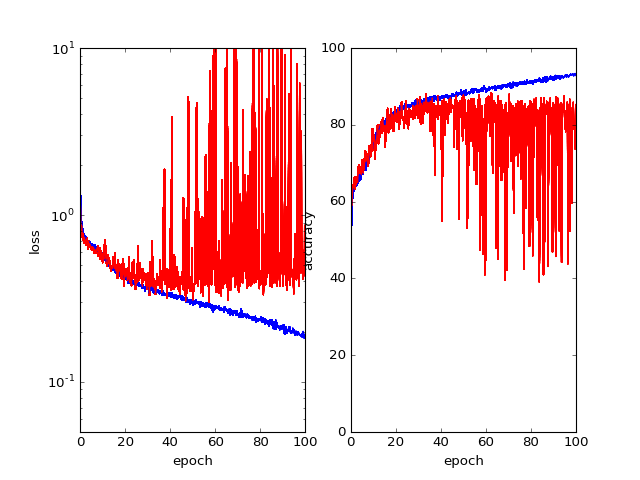

Iteration [0]: lr=1.000e-03
Iteration [0] train aveloss=1.516 aveacc=32.930
Test[0]:Result* Prec@1 43.700	Loss 1.348
Iteration [1]: lr=1.000e-03
Iteration [1] train aveloss=1.299 aveacc=44.890
Test[1]:Result* Prec@1 52.100	Loss 1.148
Iteration [2]: lr=1.000e-03
Iteration [2] train aveloss=1.055 aveacc=53.830
Test[2]:Result* Prec@1 59.500	Loss 0.893
Iteration [3]: lr=1.000e-03
Iteration [3] train aveloss=0.920 aveacc=58.850
Test[3]:Result* Prec@1 59.000	Loss 0.852
Iteration [4]: lr=1.000e-03
Iteration [4] train aveloss=0.866 aveacc=60.510
Test[4]:Result* Prec@1 61.400	Loss 0.859
Iteration [5]: lr=1.000e-03
Iteration [5] train aveloss=0.826 aveacc=62.280
Test[5]:Result* Prec@1 63.900	Loss 0.744
Iteration [6]: lr=1.000e-03
Iteration [6] train aveloss=0.817 aveacc=62.480
Test[6]:Result* Prec@1 64.200	Loss 0.728
Iteration [7]: lr=1.000e-03
Iteration [7] train aveloss=0.793 aveacc=63.020
Test[7]:Result* Prec@1 64.400	Loss 0.775
Iteration [8]: lr=1.000e-03
Iteration [8] train aveloss=0.767 av

Test[68]:Result* Prec@1 80.800	Loss 0.462
Iteration [69]: lr=1.000e-03
Iteration [69] train aveloss=0.485 aveacc=80.140
Test[69]:Result* Prec@1 79.400	Loss 0.491
Iteration [70]: lr=1.000e-03
Iteration [70] train aveloss=0.483 aveacc=79.860
Test[70]:Result* Prec@1 77.800	Loss 0.496
Iteration [71]: lr=1.000e-03
Iteration [71] train aveloss=0.481 aveacc=80.830
Test[71]:Result* Prec@1 81.900	Loss 0.483
Iteration [72]: lr=1.000e-03
Iteration [72] train aveloss=0.469 aveacc=81.060
Test[72]:Result* Prec@1 80.500	Loss 0.478
Iteration [73]: lr=1.000e-03
Iteration [73] train aveloss=0.489 aveacc=80.470
Test[73]:Result* Prec@1 78.500	Loss 0.553
Iteration [74]: lr=1.000e-03
Iteration [74] train aveloss=0.474 aveacc=80.960
Test[74]:Result* Prec@1 79.200	Loss 0.560
Iteration [75]: lr=1.000e-03
Iteration [75] train aveloss=0.467 aveacc=80.810
Test[75]:Result* Prec@1 79.000	Loss 0.503
Iteration [76]: lr=1.000e-03
Iteration [76] train aveloss=0.482 aveacc=79.980
Test[76]:Result* Prec@1 79.800	Loss 0.47

Iteration [136] train aveloss=0.379 aveacc=85.260
Test[136]:Result* Prec@1 82.100	Loss 0.473
Iteration [137]: lr=1.000e-03
Iteration [137] train aveloss=0.363 aveacc=85.690
Test[137]:Result* Prec@1 82.300	Loss 0.439
Iteration [138]: lr=1.000e-03
Iteration [138] train aveloss=0.370 aveacc=85.760
Test[138]:Result* Prec@1 85.100	Loss 0.373
Iteration [139]: lr=1.000e-03
Iteration [139] train aveloss=0.375 aveacc=85.210
Test[139]:Result* Prec@1 81.600	Loss 0.473
Iteration [140]: lr=1.000e-03
Iteration [140] train aveloss=0.380 aveacc=84.790
Test[140]:Result* Prec@1 84.800	Loss 0.415
Iteration [141]: lr=1.000e-03
Iteration [141] train aveloss=0.364 aveacc=85.520
Test[141]:Result* Prec@1 84.100	Loss 0.449
Iteration [142]: lr=1.000e-03
Iteration [142] train aveloss=0.367 aveacc=85.750
Test[142]:Result* Prec@1 82.400	Loss 0.437
Iteration [143]: lr=1.000e-03
Iteration [143] train aveloss=0.363 aveacc=85.610
Test[143]:Result* Prec@1 81.900	Loss 0.435
Iteration [144]: lr=1.000e-03
Iteration [144] 

Iteration [203]: lr=1.000e-03
Iteration [203] train aveloss=0.323 aveacc=87.410
Test[203]:Result* Prec@1 55.000	Loss 3.883
Iteration [204]: lr=1.000e-03
Iteration [204] train aveloss=0.339 aveacc=86.930
Test[204]:Result* Prec@1 83.000	Loss 0.428
Iteration [205]: lr=1.000e-03
Iteration [205] train aveloss=0.331 aveacc=86.920
Test[205]:Result* Prec@1 82.100	Loss 0.537
Iteration [206]: lr=1.000e-03
Iteration [206] train aveloss=0.325 aveacc=87.090
Test[206]:Result* Prec@1 85.600	Loss 0.385
Iteration [207]: lr=1.000e-03
Iteration [207] train aveloss=0.327 aveacc=87.390
Test[207]:Result* Prec@1 86.700	Loss 0.358
Iteration [208]: lr=1.000e-03
Iteration [208] train aveloss=0.316 aveacc=87.590
Test[208]:Result* Prec@1 84.500	Loss 0.408
Iteration [209]: lr=1.000e-03
Iteration [209] train aveloss=0.327 aveacc=87.450
Test[209]:Result* Prec@1 77.300	Loss 0.575
Iteration [210]: lr=1.000e-03
Iteration [210] train aveloss=0.329 aveacc=87.360
Test[210]:Result* Prec@1 85.800	Loss 0.370
Iteration [211]:

Test[269]:Result* Prec@1 86.600	Loss 0.358
Iteration [270]: lr=1.000e-03
Iteration [270] train aveloss=0.286 aveacc=89.440
Test[270]:Result* Prec@1 85.000	Loss 0.371
Iteration [271]: lr=1.000e-03
Iteration [271] train aveloss=0.297 aveacc=88.160
Test[271]:Result* Prec@1 76.900	Loss 0.972
Iteration [272]: lr=1.000e-03
Iteration [272] train aveloss=0.293 aveacc=88.710
Test[272]:Result* Prec@1 74.500	Loss 0.798
Iteration [273]: lr=1.000e-03
Iteration [273] train aveloss=0.295 aveacc=88.530
Test[273]:Result* Prec@1 86.700	Loss 0.328
Iteration [274]: lr=1.000e-03
Iteration [274] train aveloss=0.283 aveacc=89.170
Test[274]:Result* Prec@1 68.300	Loss 0.912
Iteration [275]: lr=1.000e-03
Iteration [275] train aveloss=0.286 aveacc=89.270
Test[275]:Result* Prec@1 83.100	Loss 0.528
Iteration [276]: lr=1.000e-03
Iteration [276] train aveloss=0.291 aveacc=89.060
Test[276]:Result* Prec@1 84.800	Loss 0.382
Iteration [277]: lr=1.000e-03
Iteration [277] train aveloss=0.280 aveacc=89.430
Test[277]:Result

Iteration [336] train aveloss=0.260 aveacc=90.250
Test[336]:Result* Prec@1 77.200	Loss 0.653
Iteration [337]: lr=1.000e-03
Iteration [337] train aveloss=0.255 aveacc=90.210
Test[337]:Result* Prec@1 79.300	Loss 0.590
Iteration [338]: lr=1.000e-03
Iteration [338] train aveloss=0.266 aveacc=89.850
Test[338]:Result* Prec@1 76.700	Loss 0.713
Iteration [339]: lr=1.000e-03
Iteration [339] train aveloss=0.250 aveacc=90.460
Test[339]:Result* Prec@1 83.800	Loss 0.430
Iteration [340]: lr=1.000e-03
Iteration [340] train aveloss=0.265 aveacc=90.020
Test[340]:Result* Prec@1 67.600	Loss 1.007
Iteration [341]: lr=1.000e-03
Iteration [341] train aveloss=0.258 aveacc=90.240
Test[341]:Result* Prec@1 81.300	Loss 0.624
Iteration [342]: lr=1.000e-03
Iteration [342] train aveloss=0.267 aveacc=90.330
Test[342]:Result* Prec@1 39.600	Loss 12.274
Iteration [343]: lr=1.000e-03
Iteration [343] train aveloss=0.260 aveacc=90.190
Test[343]:Result* Prec@1 85.300	Loss 0.400
Iteration [344]: lr=1.000e-03
Iteration [344]

Iteration [403]: lr=1.000e-03
Iteration [403] train aveloss=0.228 aveacc=91.100
Test[403]:Result* Prec@1 45.900	Loss 10.156
Iteration [404]: lr=1.000e-03
Iteration [404] train aveloss=0.241 aveacc=90.550
Test[404]:Result* Prec@1 85.000	Loss 0.383
Iteration [405]: lr=1.000e-03
Iteration [405] train aveloss=0.232 aveacc=91.150
Test[405]:Result* Prec@1 71.500	Loss 1.012
Iteration [406]: lr=1.000e-03
Iteration [406] train aveloss=0.233 aveacc=91.470
Test[406]:Result* Prec@1 86.600	Loss 0.332
Iteration [407]: lr=1.000e-03
Iteration [407] train aveloss=0.228 aveacc=91.140
Test[407]:Result* Prec@1 79.200	Loss 0.763
Iteration [408]: lr=1.000e-03
Iteration [408] train aveloss=0.230 aveacc=91.440
Test[408]:Result* Prec@1 86.300	Loss 0.436
Iteration [409]: lr=1.000e-03
Iteration [409] train aveloss=0.222 aveacc=91.620
Test[409]:Result* Prec@1 85.100	Loss 0.396
Iteration [410]: lr=1.000e-03
Iteration [410] train aveloss=0.237 aveacc=91.270
Test[410]:Result* Prec@1 86.300	Loss 0.379
Iteration [411]

Test[469]:Result* Prec@1 83.900	Loss 0.471
Iteration [470]: lr=1.000e-03
Iteration [470] train aveloss=0.199 aveacc=92.430
Test[470]:Result* Prec@1 83.400	Loss 0.432
Iteration [471]: lr=1.000e-03
Iteration [471] train aveloss=0.209 aveacc=92.250
Test[471]:Result* Prec@1 85.400	Loss 0.405
Iteration [472]: lr=1.000e-03
Iteration [472] train aveloss=0.205 aveacc=92.520
Test[472]:Result* Prec@1 83.900	Loss 0.419
Iteration [473]: lr=1.000e-03
Iteration [473] train aveloss=0.206 aveacc=92.410
Test[473]:Result* Prec@1 87.500	Loss 0.336
Iteration [474]: lr=1.000e-03
Iteration [474] train aveloss=0.197 aveacc=92.720
Test[474]:Result* Prec@1 79.000	Loss 0.543
Iteration [475]: lr=1.000e-03
Iteration [475] train aveloss=0.196 aveacc=92.730
Test[475]:Result* Prec@1 83.600	Loss 0.453
Iteration [476]: lr=1.000e-03
Iteration [476] train aveloss=0.190 aveacc=93.030
Test[476]:Result* Prec@1 78.200	Loss 0.770
Iteration [477]: lr=1.000e-03
Iteration [477] train aveloss=0.198 aveacc=92.640
Test[477]:Result

In [16]:
best_prec1 = 0.0

# define plots
fig,axs = plt.subplots(1,2)
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')
axs[0].set_ylim(5e-2,10.0)
axs[0].set_yscale("log")

axs[1].set_xlabel('epoch')
axs[1].set_ylabel('accuracy')
axs[1].set_ylim(0.0,100.0)

# iterations:
# there are 50k events in the training set
# we use 10k images per training iteration
# therefore, 1 epoch is 5 iterations
start_iteration = 5*start_epoch
end_iteration   = 5*epochs
num_iterations  = end_iteration - start_iteration
x = np.linspace(start_epoch,epochs,num_iterations)

# numpy arrays for loss and accuracy
y_train_loss = np.zeros(num_iterations)
y_train_acc  = np.zeros(num_iterations)
y_valid_loss = np.zeros(num_iterations)
y_valid_acc  = np.zeros(num_iterations)


for iiter in range(0,num_iterations):
    
    iteration = start_iteration + iiter
    epoch = float(iteration)/5.0
    
    # set the learning rate
    adjust_learning_rate(optimizer, iteration, lr)
    iterout = "Iteration [%d]: "%(iteration)
    for param_group in optimizer.param_groups:
        iterout += "lr=%.3e"%(param_group['lr'])
    print iterout

    # train for one iteration                                                                                                                                                                               
    try:
        train_ave_loss, train_ave_acc = train(iotrain, model, criterion, optimizer, 
                                              nbatches_per_iteration, iteration, -1)
    except Exception,e:
        print "Error in training routine!"
        print e.message
        print e.__class__.__name__
        traceback.print_exc(e)
        break
    print "Iteration [%d] train aveloss=%.3f aveacc=%.3f"%(iteration,
                                                           train_ave_loss,
                                                           train_ave_acc)
    y_train_loss[iiter] = train_ave_loss
    y_train_acc[iiter]  = train_ave_acc

    # evaluate on validation set                                                                                                                                                                        
    try:
        prec1,valid_loss = validate(iovalid, model, criterion, nbatches_per_valid, -1)
    except Exception,e:
        print "Error in validation routine!"
        print e.message
        print e.__class__.__name__
        traceback.print_exc(e)
        break
    print "Test[%d]:Result* Prec@1 %.3f\tLoss %.3f"%(iteration,prec1,valid_loss)
    y_valid_loss[iiter] = valid_loss
    y_valid_acc[iiter]  = prec1
        
    # plot up to current iteration
    axs[0].plot(x[:iiter+1],y_train_loss[:iiter+1],'b')
    axs[0].plot(x[:iiter+1],y_valid_loss[:iiter+1],'r')
    
    # plot up to current iteration
    axs[1].plot(x[:iiter+1],y_train_acc[:iiter+1],'b')
    axs[1].plot(x[:iiter+1],y_valid_acc[:iiter+1],'r')
    
    fig.canvas.draw()
    
    # remember best prec@1 and save checkpoint                                                                                                                                                          
    is_best = prec1 > best_prec1
    best_prec1 = max(prec1, best_prec1)
    save_checkpoint({
        'epoch': iteration + 1,
        'state_dict': model.state_dict(),
        'best_prec1': best_prec1,
        'optimizer' : optimizer.state_dict(),
    }, is_best, -1)
    if iteration%50==0:
        save_checkpoint({
            'epoch': iteration + 1,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
            'optimizer' : optimizer.state_dict(),
        }, False, iteration)


In [17]:
# once the training is over. stop the fillers
iotrain.stop()
iovalid.stop()

## Observations from training

For the first 30 epochs (150 iterations), the training is going well. The average loss for the training data (blue) and validation data (red) are dropping steadily and doing so together.

After epoch 30, the training loss keeps lowering.  However, the training and validation losses are separating. The validation loss stops improving and becomes very variable.    These are both hallmarks of overtraining.

Looking at the standard output, the accuracy of the validation gets stuck at about 85%.  This is expected with our training data. The 15% of events involves images where the labels are inaccurate. For example, a proton interacts with a nucleus producing a bunch of photons. Or a muon decays early into an electron.  Refer to the blog post about version 0.1.0 of the open training data. This means we probably hit the accuracy limit.

This is why we saved a checkpoint every 50 iterations.  You'll find `checkpoint.Xth.tar` files in the folder where this notebook is located. We can use the model saved at epoch 30 (i.e. `checkpoint.150th.tar`).  In a subsequent post, we'll look at the performance of that model.